In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import pinocchio as pin
import meshcat
import time
from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF
from pymoo.algorithms.soo.nonconvex.pso import PSO
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import SingleCriterionProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import ZRRReward
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L, get_preset_by_index, MutationType
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
from auto_robot_design.optimization.saver import ProblemSaver
from auto_robot_design.motion_planning.trajectory_ik_manager import TrajectoryIKManager
from pinocchio.visualize import MeshcatVisualizer
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML, IFrame
import asyncio
from auto_robot_design.motion_planning.trajectory_ik_manager import TrajectoryIKManager
from auto_robot_design.simulation.trajectory_movments import TrajectoryMovements
pin.seed(1)



In [2]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

In [3]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_workspace_trajectory([-0.15, -0.35], 0.14, 0.3, 30, 60)))
# ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
#     starting_point=[-0.1, -0.31], step_height=0.05, step_width=0.2, n_points=50))

ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14, -0.34], step_height=0.12, step_width=0.28, n_points=100)))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14 + 0.015, -0.34], step_height=0.10, step_width=-2*(-0.14 + 0.015), n_points=100)))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14 + 0.025 , -0.34], step_height=0.08, step_width=-2*(-0.14 + 0.025), n_points=100)))

central_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, 0, 100)))

left_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, -0.12, 100)))

right_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, 0.12, 100)))

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
# soft_constrain = PositioningConstrain(
#     error_calculator=error_calculator, points=[workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1])



In [4]:
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

In [5]:
# set the rewards and weights for the optimization task
zrr = ZRRReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")

In [6]:
class SetCamTarget:
    """Set the camera target point."""
    __slots__ = ["value"]
    def __init__(self, pos):
        self.value = pos

    def lower(self):
        return {
            u"type": "set_target",
            u"path": "",
            u"value": list(self.value)
        }
    

def add_trajectory_to_vis(pin_vis, trajectory):
    material = meshcat.geometry.MeshPhongMaterial()
    material.color = int(0xFF00FF)
    material.opacity = 0.3
    for idx, point in enumerate(trajectory):
        ballID = "world/ball" + str(idx)
        pin_vis.viewer[ballID].set_object(meshcat.geometry.Sphere(0.01), material)
        T = np.r_[np.c_[np.eye(3), point[:3]], np.array([[0, 0, 0, 1]])]
        pin_vis.viewer[ballID].set_transform(T)


### First step: Choose the topology for optimization
### Second step: Choose the placement of an actuator and trajectory
### Third step: results

In [11]:
objects = {f'Topology_{i}': get_preset_by_index_with_bounds(i) for i in range(9)}

# Create widget for meshcat output
output = widgets.Output()
output_1 = widgets.Output()
output_2 = widgets.Output()
output_3 = widgets.Output()
# Create the radio button widget
radio_buttons = widgets.RadioButtons(
    options=objects,
    description='Choose a topology for optimization:',
    disabled=False
)
# Set initial value to None
radio_buttons.value = None

proceed_button = widgets.Button(description='Confirm choice',
                                layout=widgets.Layout(width='200px', height='40px'))  # Set width and height)
proceed_button.style.button_color = 'lightgreen' 
# global variables
slider_value = None
trajectory = None
n_moving_joint = -1
active_joint = None
# Set initial value of the gm
gm:GraphManager2L = get_preset_by_index_with_bounds(-1)
_values = gm.generate_central_from_mutation_range()
gm.get_graph(_values)
fixed_robot, free_robot = jps_graph2pinocchio_robot(gm.graph, builder)

visualizer = MeshcatVisualizer(
    fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
visualizer.viewer = meshcat.Visualizer()
#isualizer.viewer.window.send(SetCamTarget([0,-0.3,0]))
visualizer.viewer["/Background"].set_property("visible", False)
visualizer.viewer["/Grid"].set_property("visible", False)
visualizer.viewer["/Axes"].set_property("visible", False)
visualizer.viewer["/Cameras/default/rotated/<object>"].set_property("position", [0,0.,0.6])
visualizer.clean()
visualizer.loadViewerModel()
visualizer.display(pin.neutral(fixed_robot.model))
with output:
    output.clear_output(wait = True)
    display(IFrame(src=visualizer.viewer.url(), width='400px', height='400px'))


def run_optimization():
    global trajectory, gm
    reward_manager = RewardManager(crag=crag)
    reward_manager.add_trajectory(trajectory, 0)
    reward_manager.add_reward(zrr, 0, 1)
    N_PROCESS = 8
    pool = multiprocessing.Pool(N_PROCESS)
    runner = StarmapParallelization(pool.starmap)

    population_size = 32
    n_generations = 10

    # create the problem for the current optimization
    with output_2:
        print("Optimization...")
    problem = SingleCriterionProblem(gm, builder, reward_manager,
                                soft_constrain, 
                                elementwise_runner=runner,
                                    Actuator=actuator)
    saver = ProblemSaver(problem, f"widget\\{gm.name}"+f"_{slider_value}", True)
    saver.save_nonmutable()
    algorithm = PSO(pop_size=population_size, save_history=True)
    optimizer = PymooOptimizer(problem, algorithm, saver)
    res = optimizer.run(
        True, **{
            "seed": 1,
            "termination": ("n_gen", n_generations),
            "verbose": False
        })

    best_id = np.argmin(optimizer.history["F"])
    best_x = optimizer.history["X"][best_id]
    graph = gm.get_graph(best_x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(gm.graph,builder)
    visualizer = MeshcatVisualizer(
        fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
    visualizer.viewer = meshcat.Visualizer()
    #isualizer.viewer.window.send(SetCamTarget([0,-0.3,0]))
    visualizer.viewer["/Background"].set_property("visible", False)
    visualizer.viewer["/Grid"].set_property("visible", False)
    visualizer.viewer["/Axes"].set_property("visible", False)
    visualizer.viewer["/Cameras/default/rotated/<object>"].set_property("position", [0,0.,0.6])
    visualizer.clean()
    add_trajectory_to_vis(visualizer, trajectory)
    visualizer.loadViewerModel()
    visualizer.display(pin.neutral(fixed_robot.model))
    with output_2:
        display(IFrame(src=visualizer.viewer.url(), width='400px', height='400px'))

def go_to_point(robot, point):
    to_start_from_init = add_auxilary_points_to_trajectory(np.array([point]).T)
    traj_6d = convert_x_y_to_6d_traj_xz(to_start_from_init[0], to_start_from_init[1])
    traj_manager = TrajectoryIKManager()
    traj_manager.register_model(robot.model, robot.constraint_models)
    traj_manager.set_solver(traj_manager.default_name)
    pos, q_arrs, __, reach_array = traj_manager.follow_trajectory(traj_6d, np.zeros(robot.model.nq))
    result_q = np.zeros(robot.model.nq)
    if reach_array[-1]:
        result_q = q_arrs[-1]
    else:
        raise Exception("Point is not reachable")
    return result_q

def simulate(out):
    global gm, trajectory
    robo, __ = jps_graph2pinocchio_robot(gm.graph, builder)
    name_ee = "EE"
    point = trajectory[50,[0,2]]
    start_q = go_to_point(robo, point)
    test = TrajectoryMovements(trajectory[:,[0,2]][[50, 75, 99],:], 1, 0.01, name_ee)
    pin.framesForwardKinematics(robo.model, robo.data, start_q)
    # # q, vq, acc, tau, pos_ee, power
    __, __, __, tau_arr, pos_ee, __ = test.simulate(robo, start_q, False)
    # des_traj = np.array(ground_symmetric_step1).T
    # plt.plot(pos_ee[:,0], pos_ee[:,2])
    # plt.plot(des_traj[:,0], des_traj[:,1], ".")
    with out:
        plt.plot(tau_arr)
        plt.show()
# create and attach callback to the radio_buttons change
def on_selection_change(change):
    global gm, visualizer
    #output.clear_output(wait=True)
    gm = change['new']
    values = gm.generate_central_from_mutation_range()
    gm.get_graph(values)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(gm.graph,builder)
    visualizer.model = fixed_robot.model
    visualizer.collision = fixed_robot.visual_model
    visualizer.visual_model = fixed_robot.visual_model
    visualizer.rebuildData()
    visualizer.clean()
    visualizer.loadViewerModel()
    visualizer.display(pin.neutral(fixed_robot.model))
radio_buttons.observe(on_selection_change, names='value')

def on_slider_change(change):
    global n_moving_joint, slider_value, visualizer, gm
    values = gm.generate_central_from_mutation_range()
    slider_value = change['new']
    values[n_moving_joint] = change['new']
    gm.get_graph(values)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(gm.graph,builder)
    visualizer.model = fixed_robot.model
    visualizer.collision = fixed_robot.visual_model
    visualizer.visual_model = fixed_robot.visual_model
    visualizer.rebuildData()
    visualizer.clean()
    add_trajectory_to_vis(visualizer, trajectory)
    visualizer.loadViewerModel()
    visualizer.display(pin.neutral(fixed_robot.model))

def on_trajectory_change(change):
    global trajectory,visualizer
    with output:
        if change['new'] == "left_vertical":
            trajectory = left_vertical
        elif change['new'] == "central_vertical":    
            trajectory = central_vertical
        elif change['new'] == "right_vertical":   
            trajectory = right_vertical
        visualizer.clean()
        add_trajectory_to_vis(visualizer, trajectory)
        visualizer.loadViewerModel()
        visualizer.display(pin.neutral(visualizer.model))
        # output.clear_output(wait = True)
        # plt.plot(trajectory[50:, 0], trajectory[50:, 2])
        # draw_joint_point(gm.graph)
        # plt.show()

def proceed_to_optimization_stage(b):
    global visualizer
    clear_output(wait = True)
    gm.freeze_joint(active_joint, active_joint.r)
    gm.set_mutation_ranges()
    #display(output)
    
    ik_manager = TrajectoryIKManager()
    fixed_robot, free_robot = jps_graph2pinocchio_robot(gm.graph, builder)
    ik_manager.register_model(fixed_robot.model, fixed_robot.constraint_models, fixed_robot.visual_model)
    ik_manager.set_solver("Closed_Loop_PI")
    #time.sleep(5)
    visualizer = MeshcatVisualizer(
        fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
    visualizer.viewer = meshcat.Visualizer()
    visualizer.viewer["/Background"].set_property("visible", False)
    visualizer.viewer["/Grid"].set_property("visible", False)
    visualizer.viewer["/Axes"].set_property("visible", False)
    visualizer.viewer["/Cameras/default/rotated/<object>"].set_property("position", [0,0,0.5])
    visualizer.clean()
    add_trajectory_to_vis(visualizer, trajectory)
    visualizer.loadViewerModel()
    display(widgets.HBox([output, output_1]))
    with output:
        visualizer.display(pin.neutral(fixed_robot.model))
        poses, q_fixed, constraint_errors,reach_array = ik_manager.follow_trajectory(trajectory, viz=visualizer)
    simulate(output_1)
    clear_output(wait = True)
    display(widgets.VBox([widgets.HBox([output, output_1]), widgets.HBox([output_2, output_3])]))
    run_optimization()
    simulate(output_3)

# Function to handle proceed button click
def proceed_to_next_stage(b):
    global active_joint, n_moving_joint, slider_value, trajectory
    if radio_buttons.value is not None:
        radio_buttons.unobserve_all()
        clear_output(wait=True)
        # this block finds the second actuator and the values for the slider
        for i, key in enumerate(list(gm.mutation_ranges.keys())):
            joint = gm.get_node_by_name(key[:-2])
            if joint.active:
                value = gm.generator_dict[joint]
                if (value.mutation_type==MutationType.ABSOLUTE or value.mutation_type==MutationType.RELATIVE) and key[-1]=="0":
                    active_joint = joint
                    values = np.round(np.linspace(gm.mutation_ranges[key][0],gm.mutation_ranges[key][1],5,endpoint=True),3)
                    n_moving_joint = i 
                elif value.mutation_type==MutationType.RELATIVE_PERCENTAGE and key[-1]=="2":
                    active_joint = joint
                    values = np.round(np.linspace(gm.mutation_ranges[active_joint.name+"_2"][0],gm.mutation_ranges[active_joint.name+"_2"][1],5,endpoint=True),3)
                    n_moving_joint = i 
        # create and start observing widgets for actuator position and trajectory choice
        slider = widgets.SelectionSlider(options=values, value=values[0], description='Chose the motor position:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, style={'description_width': '200px'}, layout=widgets.Layout(width='500px', height='50px')  )
        slider.observe(on_slider_change, names='value')
        slider_trajectory = widgets.RadioButtons(options=["left_vertical", "central_vertical","right_vertical"], value="central_vertical", description='Chose the trajectory:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, style={'description_width': '200px'}, layout=widgets.Layout(width='500px', height='100px')  )
        slider_trajectory.observe(on_trajectory_change, names='value')
        # change the button description and callback
        proceed_button.description = 'Proceed to optimization stage'
        proceed_button.on_click(proceed_to_next_stage,remove=True)
        proceed_button.on_click(proceed_to_optimization_stage)

        pos = gm.generate_central_from_mutation_range()
        print(values)
        slider_value = values[0]
        pos[n_moving_joint] = values[0]
        output.clear_output(wait = True)
        with output:
            trajectory = central_vertical
            gm.get_graph(pos)
            fixed_robot, free_robot = jps_graph2pinocchio_robot(gm.graph,builder)
            visualizer.model = fixed_robot.model
            visualizer.collision = fixed_robot.visual_model
            visualizer.visual_model = fixed_robot.visual_model
            visualizer.rebuildData()
            visualizer.clean()
            add_trajectory_to_vis(visualizer, trajectory)
            visualizer.loadViewerModel()
            visualizer.display(pin.neutral(fixed_robot.model))
            # plt.plot(trajectory[50:, 0], trajectory[50:, 2])
            # draw_joint_point(gm.get_graph(pos))
            # plt.show()
        display(HTML("""
        <style>
            .widget-radio-box label {
                color: blue !important;
            }
            /* Ensure the color stays the same when an option is selected */
            .widget-radio-box input[type="radio"]:checked + label {
                color: blue !important;
            }
        </style>
        """))
        display(widgets.HBox([widgets.VBox([slider, slider_trajectory, proceed_button]), output]))
    else:
        with output:
            print("Please make a selection first.")

proceed_button.on_click(proceed_to_next_stage)

display(HTML("""
<style>
    .widget-radio-box label {
        color: blue !important;
    }
    /* Ensure the color stays the same when an option is selected */
    .widget-radio-box input[type="radio"]:checked + label {
        color: blue !important;
    }
</style>
"""))
display(widgets.HBox([widgets.VBox([radio_buttons, proceed_button]),output]))
#display(radio_buttons, proceed_button,output)

# draw_joint_point(get_preset_by_index_with_bounds(-1).get_graph(get_preset_by_index_with_bounds(-1).generate_central_from_mutation_range()))
# plt.show()


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


NameError: name 'values' is not defined

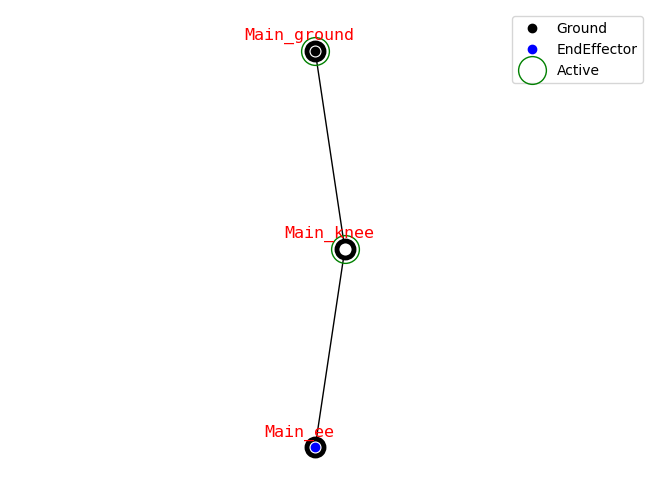

In [8]:
draw_joint_point(gm.graph)
values 


In [14]:
output

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<IPython.lib.display.IFrame at 0x21cbc…

In [ ]:
from IPython.display import IFrame
IFrame(src="http://127.0.0.1:7002/static/", width='100%', height='500px')

In [ ]:

robo, __ = jps_graph2pinocchio_robot(gm.graph, builder)

name_ee = "EE"


point = trajectory[50,[0,2]]

start_q = go_to_point(robo, point)


test = TrajectoryMovements(trajectory[:,[0,2]][[50, 75, 99],:], 1, 0.01, name_ee)
pin.framesForwardKinematics(robo.model, robo.data, start_q)

# # q, vq, acc, tau, pos_ee, power
__, __, __, tau_arr, pos_ee, __ = test.simulate(robo, start_q, False)